In [24]:
from collections.abc import Callable
import jax
import jax.numpy as jnp
from typing import Union
import jax.random as jr
from jax import grad, jit, vmap, pmap
from jax import lax
import numpy as np
from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
from jaxtyping import Array, Float, Int, PyTree  # https://github.com/google/jaxtyping
import equinox as eqx
from typing import Union, Callable
import equinox as eqx
import torchvision.transforms as transforms

In [25]:
# Hyperparameters
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
batch_size = 32
num_steps = 100000
image_size = (64, 64, 1)
height, width, channels = image_size
latent_size = 100

In [26]:
# Load the MNIST dataset using torchvision
transform = transforms.Compose(
    [
        transforms.Resize((height, width)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

data = torchvision.datasets.MNIST(root="./data", transform=transform, download=True)

dataloader = torch.utils.data.DataLoader(
    data, batch_size=batch_size, shuffle=True, num_workers=2
)

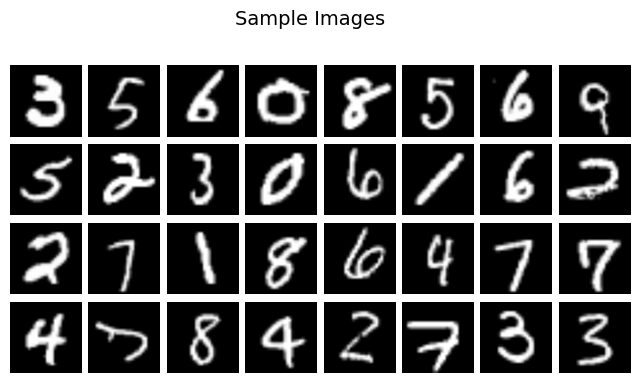

In [27]:
images, labels = next(iter(dataloader))

plot_sample = images.permute(0, 2, 3, 1)

fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(8, 4))
fig.suptitle("Sample Images", y=1.02, fontsize=14)

for ax, image in zip(sum(axes.tolist(), []), plot_sample):
    ax.imshow(image, cmap="gray")
    ax.set_axis_off()

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [28]:
dummy_x, dummy_y = next(iter(dataloader))
dummy_x = dummy_x.numpy()
dummy_y = dummy_y.numpy()
print(dummy_x.shape)  # 64x1x28x28
print(dummy_y.shape)  # 64
print(dummy_y)

(32, 1, 64, 64)
(32,)
[1 6 9 2 9 9 3 1 6 6 7 0 4 9 5 9 4 7 6 0 4 1 2 0 6 4 8 4 8 1 7 9]


In [29]:
class Generator(eqx.Module):
    linear_layer: eqx.nn.Linear
    downsample_layers_01: list
    input_size: tuple[int, int, int]

    def __init__(self, latent_size, input_size, key: jr.PRNGKey):
        keys = jr.split(key, 6)  # Precisamos de 6 chaves, uma para cada camada
        self.input_size = input_size

        # Primeiro, transforma o vetor latente em um tensor que pode ser processado por camadas convolucionais
        self.linear_layer = eqx.nn.Linear(in_features=latent_size, out_features=512 * 1 * 1, key=keys[0])

        self.downsample_layers_01 = [
            eqx.nn.BatchNorm(input_size=512, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            # Upsampling progressivo
            eqx.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[1]),
            eqx.nn.BatchNorm(input_size=256, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[2]),
            eqx.nn.BatchNorm(input_size=128, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[3]),
            eqx.nn.BatchNorm(input_size=64, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[4]),
            eqx.nn.BatchNorm(input_size=32, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            
            eqx.nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[5]),
            eqx.nn.BatchNorm(input_size=16, axis_name=("batch",)),
            jax.nn.leaky_relu,
            
            eqx.nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=4, stride=2, padding=1, use_bias=False, key=keys[6]),
            jax.nn.tanh  # Gera uma imagem com valores de pixel no intervalo [-1, 1]
        ]

    def __call__(self, x, state):
        x = self.linear_layer(x)
        x = x.reshape(x.shape[0], 1, 1)  # Redimensiona para a forma desejada para convolução
        
        
        for layer in self.downsample_layers_01:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state)
            elif callable(layer):
                x = layer(x)
            else:
                x = layer(x)
            
        
            
        return x, state

In [30]:
class Discriminator(eqx.Module):
    downsample_layers: list
    upsample_layers: list
    batchnorm_layers: list

    def __init__(self, input_shape, key: jr.PRNGKey):
        
        input_shape: int
        keys = jr.split(key, 10)
        self.downsample_layers = []
        self.upsample_layers = []
        self.batchnorm_layers = []
        channels = [input_shape, 64, 128, 256, 512]
        
        for i in range(len(channels)-1):
            self.downsample_layers += [
            eqx.nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=3, stride=1, padding=1, use_bias=False, key=keys[0]),
            eqx.nn.BatchNorm(input_size=channels[i+1], axis_name="batch"),
            jax.nn.relu,
            
            eqx.nn.Conv2d(in_channels=channels[i+1], out_channels=channels[i+1], kernel_size=3, stride=1, padding=1, use_bias=False, key=keys[0]),
            eqx.nn.BatchNorm(input_size=channels[i+1], axis_name="batch"),
            jax.nn.relu,
            eqx.nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            ]
            
        for i in range(1, len(channels)):
            self.upsample_layers += [
            eqx.nn.ConvTranspose2d(channels[-i], channels[-i-1], kernel_size=2, stride=2, padding=0, use_bias=False, key=keys[4+i]),
            eqx.nn.BatchNorm(channels[-i-1], axis_name="batch"),
            jax.nn.relu,
            eqx.nn.Conv2d(channels[-i-1], channels[-i-1], kernel_size=3, stride=1, padding=1, use_bias=False, key=keys[5+i]),
            eqx.nn.BatchNorm(channels[-i-1], axis_name="batch"),
            jax.nn.relu,
            ]
            
    def __call__(self, x, state):
        skips = []
        for layer in self.downsample_layers:
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state)
            elif callable(layer):  # Para funções como jax.nn.relu
                x = layer(x)
            else:
                x = layer(x)
            print(f"Após {type(layer).__name__}: {x.shape}")
            
            if isinstance(layer, eqx.nn.Conv2d):
                skips.append(x)
            
                    # Aplicar upsampling e usar conexões de salto
        for idx, layer in enumerate(self.upsample_layers):
            if isinstance(layer, eqx.nn.BatchNorm):
                x, state = layer(x, state)
            elif callable(layer):
                x = layer(x)
            elif isinstance(layer, eqx.nn.ConvTranspose2d):
                x = layer(x)
                skip = skips.pop()  # Recuperar a última conexão de salto
                x = jnp.concatenate((x, skip), axis=1)  # Concatenar com a conexão de salto
            else:
                x = layer(x)
            
            print(f"Após {layer.__class__.__name__}: {x.shape}")
            print(skips)
            
        return jax.nn.sigmoid(x), state
        

(100, 100)
-0.9341284
0.77789843


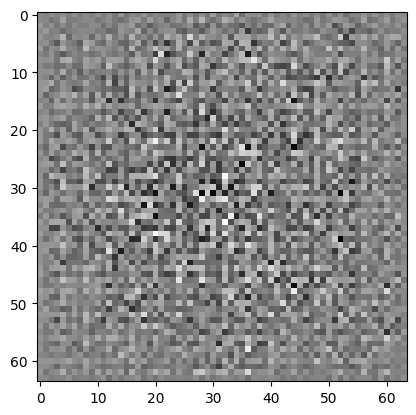

In [31]:
key = jr.PRNGKey(1)
latent_size = 100
input_size = (1, 1, 1)

generator, state = eqx.nn.make_with_state(Generator)(latent_size, input_size, key)

test_tensor = jr.normal(key, (100, latent_size))

print(test_tensor.shape)

output, state = jax.vmap(generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(test_tensor, state)

images = output
print(images.min())
print(images.max())
images = (images - images.min()) / (images.max() - images.min())
plt.imshow(images[0, 0], cmap='gray')
plt.show()

In [32]:
seed = 2
key = jr.PRNGKey(seed)
mkey, xkey, xkey2 = jr.split(key, 3)
input_shape = (64, 64, 1)
width, height, channels = input_shape

#Inicia o modelo e o estado com as variaveis que foram definidas no Init
discriminator, state = eqx.nn.make_with_state(Discriminator)(channels, key)

test_tensor = jr.normal(xkey, (100, 1, width, height))

output, state = jax.vmap(discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(test_tensor, state)

images = output

Após Conv2d: (64, 64, 64)
Após BatchNorm: (64, 64, 64)
Após custom_jvp: (64, 64, 64)
Após Conv2d: (64, 64, 64)
Após BatchNorm: (64, 64, 64)
Após custom_jvp: (64, 64, 64)
Após MaxPool2d: (64, 32, 32)
Após Conv2d: (128, 32, 32)
Após BatchNorm: (128, 32, 32)
Após custom_jvp: (128, 32, 32)
Após Conv2d: (128, 32, 32)
Após BatchNorm: (128, 32, 32)
Após custom_jvp: (128, 32, 32)
Após MaxPool2d: (128, 16, 16)
Após Conv2d: (256, 16, 16)
Após BatchNorm: (256, 16, 16)
Após custom_jvp: (256, 16, 16)
Após Conv2d: (256, 16, 16)
Após BatchNorm: (256, 16, 16)
Após custom_jvp: (256, 16, 16)
Após MaxPool2d: (256, 8, 8)
Após Conv2d: (512, 8, 8)
Após BatchNorm: (512, 8, 8)
Após custom_jvp: (512, 8, 8)
Após Conv2d: (512, 8, 8)
Após BatchNorm: (512, 8, 8)
Após custom_jvp: (512, 8, 8)
Após MaxPool2d: (512, 4, 4)
Após ConvTranspose2d: (256, 8, 8)
[Traced<ShapedArray(float32[64,64,64])>with<BatchTrace(level=1/0)> with
  val = Array([[[[-1.86051995e-01, -2.45440513e-01, -7.92912841e-02, ...,
           3.732468

In [43]:
@eqx.filter_value_and_grad(has_aux=True)
def compute_grads_generator(generator, discriminator, real_labels, discriminator_state, generator_state, key):
    key, subkey = jr.split(key)
    noise = jr.normal(subkey, (batch_size, latent_size))

    fake_batch, generator_state = jax.vmap(generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(noise, generator_state)

    pred_y, discriminator_state = jax.vmap(discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(fake_batch, discriminator_state)
    
    loss = optax.sigmoid_binary_cross_entropy(pred_y, real_labels).mean()

    return loss, (discriminator_state, generator_state, key)

In [44]:
@eqx.filter_value_and_grad(has_aux=True)
def compute_grads_discriminator(discriminator, generator, fake_labels, real_batch, real_labels, discriminator_state, generator_state, key):
    key, subkey = jr.split(key)
    noise = jr.normal(subkey, (batch_size, latent_size))

    fake_batch, generator_state = jax.vmap(generator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(noise, generator_state)

    pred_y, discriminator_state = jax.vmap(discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(fake_batch, discriminator_state)
    loss1 = optax.sigmoid_binary_cross_entropy(pred_y, fake_labels).mean()

    pred_y, discriminator_state = jax.vmap(discriminator, axis_name="batch", in_axes=(0, None), out_axes=(0, None))(real_batch, discriminator_state)
    
    loss2 = optax.sigmoid_binary_cross_entropy(pred_y, real_labels).mean()

    loss = (loss1 + loss2) / 2

    return loss, (discriminator_state, generator_state, key)

In [45]:
@eqx.filter_jit
def step_discriminator(
    discriminator: Discriminator,
    generator: Generator,
    real_batch: jnp.ndarray,
    discriminator_optimizer: optax.GradientTransformation,
    discriminator_opt_state: optax.OptState,
    generator_state: eqx.nn.State,
    discriminator_state: eqx.nn.State,
    key: jr.PRNGKey,
):

    fake_labels = jnp.zeros(batch_size)
    real_labels = jnp.ones(batch_size)

    # Calcula a perda e os gradientes para o discriminador
    (loss, (discriminator_state, generator_state, key)), grads = compute_grads_discriminator(
        discriminator,
        generator,
        fake_labels,
        real_batch,
        real_labels,
        discriminator_state,
        generator_state,
        key,
    )

    # Atualiza os parâmetros do discriminador com base nos gradientes
    updates, opt_state = discriminator_optimizer.update(
        grads, discriminator_opt_state, discriminator
    )
    discriminator = eqx.apply_updates(discriminator, updates)

    # Retorna a perda e os estados atualizados
    return loss, discriminator, opt_state, generator_state, discriminator_state, key



In [46]:
@eqx.filter_jit
def step_generator(
    generator: Generator,
    discriminator: Discriminator,
    generator_optimizer: optax.GradientTransformation,
    generator_opt_state: optax.OptState,
    discriminator_state: eqx.nn.State,
    generator_state: eqx.nn.State,
    key: jr.PRNGKey,
):
    real_labels = jnp.ones(batch_size)

    (
        loss,
        (discriminator_state, generator_state, key),
    ), grads = compute_grads_generator(
        generator, discriminator, real_labels, discriminator_state, generator_state, key
    )

    updates, opt_state = generator_optimizer.update(grads, generator_opt_state)
    generator = eqx.apply_updates(generator, updates)

    return loss, generator, opt_state, discriminator_state, generator_state, key

In [47]:

def train(
    generator: Generator,
    discriminator: Discriminator,
    generator_optimizer: optax.GradientTransformation,
    discriminator_optimizer: optax.GradientTransformation,
    generator_opt_state: optax.OptState,
    discriminator_opt_state: optax.OptState,
    generator_state: eqx.nn.State,
    discriminator_state: eqx.nn.State,
    data_loader: torch.utils.data.DataLoader,
    num_steps: int,
    key: jr.PRNGKey,
    print_every: int = 1000,
):
    generator_losses = []
    discriminator_losses = []

    def infinite_trainloader():
        while True:
            yield from data_loader

    for step, batch in zip(range(num_steps), infinite_trainloader()):
        images, labels = batch

        (
            discriminator_loss,
            discriminator,
            discriminator_opt_state,
            generator_state,
            discriminator_state,
            key,
            
        ) = step_discriminator(
            discriminator,
            generator,
            images.numpy(),
            discriminator_optimizer,
            discriminator_opt_state,
            generator_state,
            discriminator_state,
            key,
        )

        (
            generator_loss,
            generator,
            generator_opt_state,
            discriminator_state,
            generator_state,
            key,
        ) = step_generator(
            generator,
            discriminator,
            generator_optimizer,
            generator_opt_state,
            discriminator_state,
            generator_state,
            key,
        )

        generator_losses.append(generator_loss)
        discriminator_losses.append(discriminator_loss)

        if (step % print_every) == 0 or step == num_steps - 1:
            print(
                f"Step: {step}/{num_steps}, Generator loss: {generator_loss}, "
                f"Discriminator loss: {discriminator_loss}"
            )

    return (
        generator,
        discriminator,
        generator_state,
        discriminator_state,
        generator_losses,
        discriminator_losses,
        key,
    )

In [48]:
key = jr.PRNGKey(2003)

key, gen_key, disc_key = jr.split(key, 3)

generator = Generator(latent_size, input_size, key=gen_key)
discriminator = Discriminator(input_shape=channels, key=disc_key)
generator_state = eqx.nn.State(generator)
discriminator_state = eqx.nn.State(discriminator)

generator_optimizer = optax.adam(lr, b1=beta1, b2=beta2)
discriminator_optimizer = optax.adam(lr, b1=beta1, b2=beta2)

generator_opt_state = generator_optimizer.init(eqx.filter(generator, eqx.is_array))
discriminator_opt_state = discriminator_optimizer.init(eqx.filter(discriminator, eqx.is_array))

In [49]:
(generator, discriminator, generator_state, discriminator_state, generator_losses, discriminator_losses, key,) = train(generator, discriminator, generator_optimizer, discriminator_optimizer, generator_opt_state, discriminator_opt_state, generator_state, discriminator_state, dataloader, num_steps, key,)

Após Conv2d: (64, 64, 64)
Após BatchNorm: (64, 64, 64)
Após custom_jvp: (64, 64, 64)
Após Conv2d: (64, 64, 64)
Após BatchNorm: (64, 64, 64)
Após custom_jvp: (64, 64, 64)
Após MaxPool2d: (64, 32, 32)
Após Conv2d: (128, 32, 32)
Após BatchNorm: (128, 32, 32)
Após custom_jvp: (128, 32, 32)
Após Conv2d: (128, 32, 32)
Após BatchNorm: (128, 32, 32)
Após custom_jvp: (128, 32, 32)
Após MaxPool2d: (128, 16, 16)
Após Conv2d: (256, 16, 16)
Após BatchNorm: (256, 16, 16)
Após custom_jvp: (256, 16, 16)
Após Conv2d: (256, 16, 16)
Após BatchNorm: (256, 16, 16)
Após custom_jvp: (256, 16, 16)
Após MaxPool2d: (256, 8, 8)
Após Conv2d: (512, 8, 8)
Após BatchNorm: (512, 8, 8)
Após custom_jvp: (512, 8, 8)
Após Conv2d: (512, 8, 8)
Após BatchNorm: (512, 8, 8)
Após custom_jvp: (512, 8, 8)
Após MaxPool2d: (512, 4, 4)
Após ConvTranspose2d: (256, 8, 8)
[Traced<ShapedArray(float32[64,64,64])>with<BatchTrace(level=4/0)> with
  val = Traced<ShapedArray(float32[32,64,64,64])>with<JVPTrace(level=3/0)> with
    primal = 

ValueError: Incompatible shapes for broadcasting: shapes=[(32,), (32, 1, 64, 64)]